In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = "/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/hole/000.png"

img = Image.open(image_path).convert("RGB")

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
import torch
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration
from PIL import Image
import glob

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_ID = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
model     = LlavaOnevisionForConditionalGeneration.from_pretrained(
    MODEL_ID,
    trust_remote_code   = True,
    torch_dtype         = torch.bfloat16,
    low_cpu_mem_usage   = True,
    device_map          = "auto",
).eval().to(device)

# # Anomaly Discrimination

In [7]:
# 768→1152
bridge = nn.Linear(
    768,
    model.vision_tower.config.hidden_size
).to(device, dtype=model.dtype)
bridge.load_state_dict(torch.load(
    "/home/s2behappy4/data/gyuhyeong/code/bridge_data/bridge_weights_train.pt",
    map_location=device,
))
bridge.eval()

# Q-Former 
mask_token_single = torch.load(
    "/home/s2behappy4/data/gyuhyeong/code/bridge_data/hazelnut_mask_token_single.pt",
    map_location=device
)
mask_token_single = mask_token_single.to(device)

# 768 → 1152 → 3584
mask_seq    = mask_token_single.unsqueeze(0)               
mask_seq    = mask_seq.to(device, dtype=model.dtype)
with torch.no_grad():
    bridge_out  = bridge(mask_seq)                          
    mask_embeds = model.multi_modal_projector(bridge_out)   

mask_attn = torch.ones(
    1, mask_embeds.size(1),
    device=device, dtype=torch.long
)  

prompt   = "Is there any anomaly in the image?\n### Assistant:"
tok_out  = processor.tokenizer(prompt, return_tensors="pt").to(device)
text_embeds = model.get_input_embeddings()(tok_out.input_ids)  
text_mask   = tok_out.attention_mask                       

inputs_embeds  = torch.cat([mask_embeds, text_embeds], dim=1)    
attention_mask = torch.cat([mask_attn, text_mask],   dim=1)     

with torch.no_grad():
    gen_ids = model.generate(
        inputs_embeds   = inputs_embeds,
        attention_mask  = attention_mask,
        max_new_tokens  = 50,
        do_sample       = False,
        eos_token_id    = processor.tokenizer.eos_token_id,
        pad_token_id    = processor.tokenizer.eos_token_id,
    )

answer = processor.tokenizer.batch_decode(
    gen_ids, skip_special_tokens=True
)[0]

print("Model answer:", answer)

Model answer:  Yes, there is an anomaly in the image.


# # QA

In [11]:
bridge = nn.Linear(
    768,
    model.vision_tower.config.hidden_size  
).to(device, dtype=model.dtype)
bridge.load_state_dict(torch.load(
    "/home/s2behappy4/data/gyuhyeong/code/bridge_data/bridge_weights_train.pt",
    map_location=device,
))
bridge.eval()

mask_token_single = torch.load(
    "/home/s2behappy4/data/gyuhyeong/code/bridge_data/hazelnut_mask_token_single.pt",
    map_location=device
)  
mask_token_single = mask_token_single.to(device)

mask_seq    = mask_token_single.unsqueeze(0)                
mask_seq    = mask_seq.to(device, dtype=model.dtype)
with torch.no_grad():
    bridge_out  = bridge(mask_seq)                          
    mask_embeds = model.multi_modal_projector(bridge_out)   

mask_attn = torch.ones(
    1, mask_embeds.size(1),
    device=device, dtype=torch.long
)  

prompt = (
    "1. Is there any anomaly in the image? (Yes or No)\n"
    "2. If yes, provide a detailed description of the anomaly, including its appearance (shape, color, size, texture) and any other relevant characteristics.\n"
    "3. Specify exactly where in the image the anomaly is located (e.g., \"top-left corner\", \"center right\", etc.).\n"
    "Answer **only in English**.\n"
    "### Assistant:"
)

tok_out  = processor.tokenizer(prompt, return_tensors="pt").to(device)
text_embeds = model.get_input_embeddings()(tok_out.input_ids)  
text_mask   = tok_out.attention_mask                         

inputs_embeds  = torch.cat([mask_embeds, text_embeds], dim=1)    
attention_mask = torch.cat([mask_attn, text_mask],   dim=1)     

with torch.no_grad():
    gen_ids = model.generate(
        inputs_embeds   = inputs_embeds,
        attention_mask  = attention_mask,
        max_new_tokens  = 100,
        do_sample       = False,
        eos_token_id    = processor.tokenizer.eos_token_id,
        pad_token_id    = processor.tokenizer.eos_token_id,
    )

answer = processor.tokenizer.batch_decode(
    gen_ids, skip_special_tokens=True
)[0]

print("Model answer:", answer)

Model answer:  There is an anomaly in the image. It is located in the top-right corner. The anomaly appears as a small, irregularly shaped, dark-colored spot with a slightly rough texture. Its size is approximately 1/10th the width of the image.


# # QA & Anomaly mask visualization

## ## Hazelnut

In [ ]:
from torch import nn

bridge = nn.Linear(
    768,
    model.vision_tower.config.hidden_size  
).to(device, dtype=model.dtype)
bridge.load_state_dict(torch.load(
    "/home/s2behappy4/data/gyuhyeong/code/bridge_data/bridge_weights_train.pt",
    map_location=device,
))
bridge.eval()

pair_path = "/home/s2behappy4/data/gyuhyeong/code/bridge_data/hazelnut_token_mask_pairs.pt"
pair_data = torch.load(pair_path, map_location=device)
mask_token_single = pair_data["mask_tokens"].to(device)  

mask_seq    = mask_token_single.unsqueeze(0)               
mask_seq    = mask_seq.to(device, dtype=model.dtype)
with torch.no_grad():
    bridge_out  = bridge(mask_seq)                        
    mask_embeds = model.multi_modal_projector(bridge_out)   

mask_attn = torch.ones(
    1, mask_embeds.size(1),
    device=device, dtype=torch.long
)  

prompt = (
    "1. Is there any anomaly in the image? (Yes or No)\n"
    "### Assistant:"
)

tok_out     = processor.tokenizer(prompt, return_tensors="pt").to(device)
text_embeds = model.get_input_embeddings()(tok_out.input_ids)  
text_mask   = tok_out.attention_mask                       

inputs_embeds  = torch.cat([mask_embeds, text_embeds], dim=1)   
attention_mask = torch.cat([mask_attn, text_mask],   dim=1)     

with torch.no_grad():
    gen_ids = model.generate(
        inputs_embeds   = inputs_embeds,
        attention_mask  = attention_mask,
        max_new_tokens  = 100,
        do_sample       = False,
        eos_token_id    = processor.tokenizer.eos_token_id,
        pad_token_id    = processor.tokenizer.eos_token_id,
    )

answer = processor.tokenizer.batch_decode(
    gen_ids, skip_special_tokens=True
)[0]

print("Model answer:", answer)

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Anomaly mask token indices: [16, 15, 14]


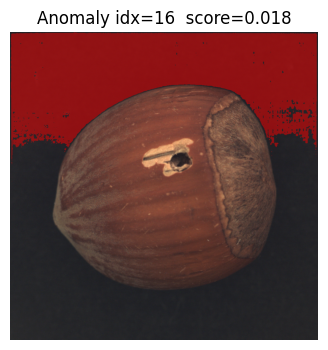

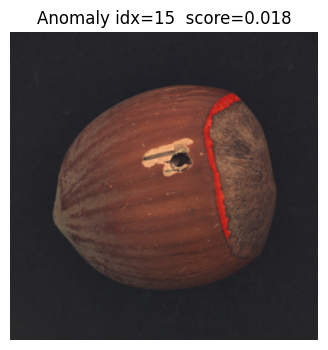

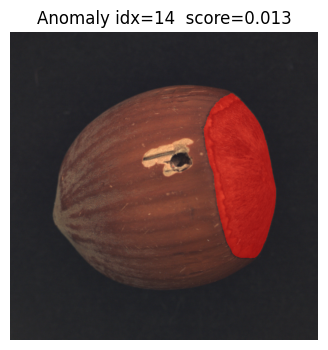

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

base_dir   = "/home/s2behappy4/data/gyuhyeong/code/overlays/hazelnut"
image_path = "/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/hole/000.png"
alpha      = 0.5  

inputs_embeds  = torch.cat([mask_embeds, text_embeds], dim=1)  
attention_mask = torch.cat([mask_attn,   text_mask],   dim=1)   

lm = model.language_model
lm_outputs = lm(
    inputs_embeds       = inputs_embeds,
    attention_mask      = attention_mask,
    output_attentions   = True,
    return_dict         = True,
)

attentions = lm_outputs.attentions

N = mask_embeds.size(1)
L = text_embeds.size(1)
device = mask_embeds.device

scores = torch.zeros(N, device=device)
for layer_attn in attentions:
    text2vision = layer_attn[0, :, N:, :N]   
    scores += text2vision.mean(dim=0).mean(dim=0) 

scores /= len(attentions)

k = 3  
anomaly_indices = torch.topk(scores, k).indices.tolist()
print("Anomaly mask token indices:", anomaly_indices)

orig = Image.open(image_path).convert("RGB")
orig_np = np.array(orig) 

for idx in anomaly_indices:
    mask_map = torch.load(f"{base_dir}/mask_{idx:02d}.pt").numpy().astype(bool)

    overlay = orig_np.astype(np.float32).copy()
    overlay[mask_map] = (1 - alpha) * orig_np[mask_map] + alpha * np.array([255, 0, 0])

    plt.figure(figsize=(4,4))
    plt.imshow(overlay.astype(np.uint8))
    plt.title(f"Anomaly idx={idx}  score={scores[idx]:.3f}")
    plt.axis("off")

plt.show()

## ## Screw

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = "/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/screw/test/scratch_neck/000.png"

img = Image.open(image_path).convert("RGB")

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
from torch import nn

bridge = nn.Linear(
    768,
    model.vision_tower.config.hidden_size  
).to(device, dtype=model.dtype)
bridge.load_state_dict(torch.load(
    "/home/s2behappy4/data/gyuhyeong/code/bridge_data/bridge_weights_train.pt",
    map_location=device,
))
bridge.eval()

pair_path = "/home/s2behappy4/data/gyuhyeong/code/bridge_data/screw_token_mask_pairs.pt"
pair_data = torch.load(pair_path, map_location=device)
mask_token_single = pair_data["mask_tokens"].to(device)

mask_seq    = mask_token_single.unsqueeze(0)                
mask_seq    = mask_seq.to(device, dtype=model.dtype)
with torch.no_grad():
    bridge_out  = bridge(mask_seq)                         
    mask_embeds = model.multi_modal_projector(bridge_out)   

mask_attn = torch.ones(
    1, mask_embeds.size(1),
    device=device, dtype=torch.long
)  

prompt = (
    "1. Is there any anomaly in the image? (Yes or No)\n"
    "2. If yes, provide a detailed description of the anomaly, including its appearance (shape, color, size, texture) and any other relevant characteristics.\n"
    "3. Specify exactly where in the image the anomaly is located (e.g., \"top-left corner\", \"center right\", etc.).\n"
    "Answer **only in English**.\n"
    "### Assistant:"
)

tok_out     = processor.tokenizer(prompt, return_tensors="pt").to(device)
text_embeds = model.get_input_embeddings()(tok_out.input_ids)  
text_mask   = tok_out.attention_mask                        

inputs_embeds  = torch.cat([mask_embeds, text_embeds], dim=1)    
attention_mask = torch.cat([mask_attn, text_mask],   dim=1)    

with torch.no_grad():
    gen_ids = model.generate(
        inputs_embeds   = inputs_embeds,
        attention_mask  = attention_mask,
        max_new_tokens  = 100,
        do_sample       = False,
        eos_token_id    = processor.tokenizer.eos_token_id,
        pad_token_id    = processor.tokenizer.eos_token_id,
    )

answer = processor.tokenizer.batch_decode(
    gen_ids, skip_special_tokens=True
)[0]

print("Model answer:", answer)

Anomaly mask token indices: [46, 45, 44]


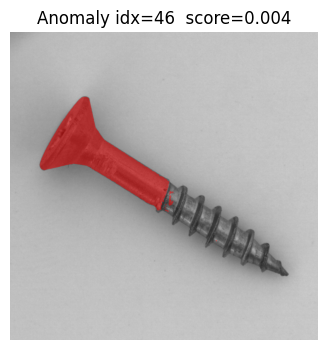

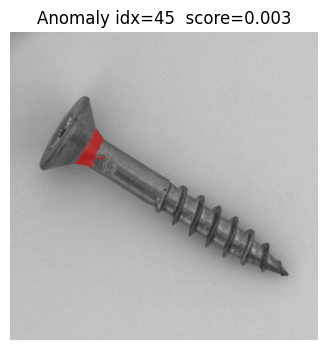

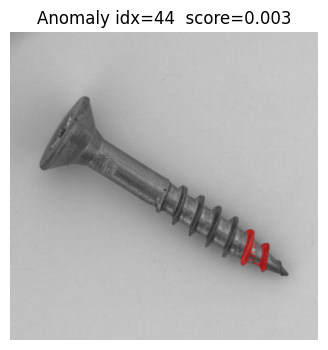

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

base_dir   = "/home/s2behappy4/data/gyuhyeong/code/overlays/screw"
image_path = "/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/screw/test/scratch_neck/000.png"
alpha      = 0.5  

inputs_embeds  = torch.cat([mask_embeds, text_embeds], dim=1)   
attention_mask = torch.cat([mask_attn,   text_mask],   dim=1)   

lm = model.language_model
lm_outputs = lm(
    inputs_embeds       = inputs_embeds,
    attention_mask      = attention_mask,
    output_attentions   = True,
    return_dict         = True,
)

attentions = lm_outputs.attentions

N = mask_embeds.size(1)
L = text_embeds.size(1)
device = mask_embeds.device

scores = torch.zeros(N, device=device)

for layer_attn in attentions:
    text2vision = layer_attn[0, :, N:, :N]  
    scores += text2vision.mean(dim=0).mean(dim=0) 

scores /= len(attentions)

k = 3 
anomaly_indices = torch.topk(scores, k).indices.tolist()
print("Anomaly mask token indices:", anomaly_indices)

orig = Image.open(image_path).convert("RGB")
orig_np = np.array(orig)  

for idx in anomaly_indices:
    mask_map = torch.load(f"{base_dir}/mask_{idx:02d}.pt").numpy().astype(bool)

    overlay = orig_np.astype(np.float32).copy()
    overlay[mask_map] = (1 - alpha) * orig_np[mask_map] + alpha * np.array([255, 0, 0])

    plt.figure(figsize=(4,4))
    plt.imshow(overlay.astype(np.uint8))
    plt.title(f"Anomaly idx={idx}  score={scores[idx]:.3f}")
    plt.axis("off")

plt.show()